## Tutorial for tissue simulation with transcriptomic profile sample from scRNAseq data

### download test data at :
https://cloud.minesparis.psl.eu/index.php/s/ZXkeiJTzD6KrjRX

In [2]:
from pathlib import Path
import tifffile
import numpy as np
from simtissue.arbitrary_shape import  generate_ellipse
import time
import random
from tqdm import tqdm
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from matplotlib import pyplot as plt
from scipy import sparse
import pandas
import scanpy

from simtissue.control_expression import filter_simulation, sim_spots_from_ref_anndata
from simtissue.tissue import simulate_single_cell_mask


### LIST OF GENE TO SIMULATE
selected_gene = ['Atp6v0d2', 'Abcg1',# AM
             'Rtkn2',  'Igfbp2', #AT1
             'Sftpc','Cxcl15', #AT2,
            'Cd79a', #B_cells
             'Ms4a2', 'Fcer1a', #Basophils
             'Ccdc153', #Ciliated
             'Scgb3a2', 'Scgb1a1',#Club
             'Cst3',#DC
             'Cdh5', 'Clec14a',  #EC
             'Inmt', 'Pcolce2', # Fibroblasts
             'C1qc', 'C1qa', 'C1qb', # 'C3ar1', #IM
             'Upk3b',# Mesotheliocytes
             'Ifitm6','Plac8',# Monocytes
            'Ms4a4b', 'Ccl5', 'Hcst', # NK_T_cells
             'Gzma', 'Ncr1',# NK_cells
             'S100a9',# Neutrophils
             'Mmrn1',#Platelets
           'Acta2','Myh11', # SMC
             'Cd3g', 'Cd3d' #T_cells
             ]

ref_anndata = scanpy.read('/media/tom/T7/simulation/test_set_simulation/test_anndata.h5ad')


### 1) Generate the cytoplasm with ``simulate_single_cell_mask()``
Individual cytoplasms are defined by growing cells from segmented nuclei. Each cell grows at a random speed to add irregularity to the cell size. the random speed are sample from the parameter ``intervals_speed`` in ``simulate_single_cell_mask()``


In [4]:
path_folder_mask_nuclei = "/media/tom/T7/simulation/test_set_simulation/mask_nuclei"
path_folder_cytoplasm = "/media/tom/T7/simulation/test_set_simulation/cytoplasm_mask"
path_save_ind_cyto = "/media/tom/T7/simulation/test_set_simulation/individual_cytoplasm"


for path_mask_nuclei in Path(path_folder_mask_nuclei).glob('*.tiff'):
    print(path_mask_nuclei)
    ##load nuclei
    mask_nuclei = tifffile.imread(path_mask_nuclei)[20:35, 200:1000, :1200]
    ## load cytoplasm
    mask_cyto = np.load(Path(path_folder_cytoplasm) / 
                                (path_mask_nuclei.name + ".npy"))[20:35, 200:1000, :1200]  
    ## 
    ind_cyto = simulate_single_cell_mask(
                            mask_nuclei,
                            cyto = mask_cyto,
                            scale=np.array([3, 1.03, 1.03]),
                            intervals_speed=[[0.5, 0.8], [1.3, 4]],
                            median_kernel=7,
                            random_seed = None
                                      )
    np.save(Path(path_save_ind_cyto) / path_mask_nuclei.stem, ind_cyto)

/media/tom/T7/simulation/test_set_simulation/mask_nuclei/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004.tiff


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


/media/tom/T7/simulation/test_set_simulation/mask_nuclei/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006.tiff


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:37<00:00,  1.19s/it]


### 2) (optional) Remove a percentage of nuclei with  ``remove_nuclei``
 Removed nuclei from arbitrary cell to mimick experimental data where many cells are separated from their nuclei during the imaging of the tissue

In [5]:
path_folder_mask_nuclei_remove = "/media/tom/T7/simulation/test_set_simulation/mask_nuclei"
Path(path_folder_mask_nuclei_remove, exist_ok=True)

from simtissue.arbitrary_shape import remove_nuclei
for path_mask_nuclei in Path(path_folder_mask_nuclei).glob('*.tiff'):
    print(path_mask_nuclei)
    print(path_mask_nuclei.name + ".npy")
    ##load nuclei
    mask_nuclei = tifffile.imread(path_mask_nuclei)[20:35, 200:1000, :1200]  
    new_mask_nuclei = remove_nuclei(
        mask_nuclei,
        percent_to_remove = 0.1,
        list_nuc_to_keep = None)
    np.save(Path(path_folder_mask_nuclei_remove) / path_mask_nuclei.stem, ind_cyto)

/media/tom/T7/simulation/test_set_simulation/mask_nuclei/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004.tiff
07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004.tiff.npy
/media/tom/T7/simulation/test_set_simulation/mask_nuclei/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006.tiff
07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006.tiff.npy


### 3) sample transcriptomic profile  with ``sim_spots_from_ref_anndata()`` and simulate position
When drawing a profile from scRNA-seq, we sample for each simulated cell an expression profile of a single cell from scRNA-seq, then multiply the number of RNAs by a fix factor (``scaling_factor`` in ``sim_spots_from_ref_anndata``)

In [6]:
path_to_save_anndata = "/media/tom/T7/simulation/test_set_simulation/anndata/"
path_to_save_df = "/media/tom/T7/simulation/test_set_simulation/dataframe/"
list_anndata = []

for path_ic in Path(path_save_ind_cyto).glob("*.npy"):
    
    cell_mask = np.load(path_ic)
    
    anndata, df_spots = sim_spots_from_ref_anndata(

        ref_anndata = ref_anndata,
        cell_mask = cell_mask,
        image_name = 'test', 
        annotation_column = "cell_ID",
        selected_gene = selected_gene,
        remove_neighbors = True,
        max_dist = 0.3,
        dict_scale = {"x":0.103, 'y':0.103, "z":0.300},
        scaling_factor=3
        )
    
    list_anndata.append(anndata)
        
    anndata.write_h5ad(str(Path(path_to_save_anndata) /(path_ic.stem + '.h5ad')))
    df_spots.to_csv(Path(path_to_save_df) /(path_ic.stem + '.npy'))                   

View of AnnData object with n_obs × n_vars = 30 × 34
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'project', 'experiment', 'singlecell_version', 'sexe', 'genotype', 'IRstatus', 'IRdose', 'timepoint', 'sorted', 'condition', 'percent.mt', 'nCount_RNAraw', 'nFeature_RNAraw', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'cell_ID', 'sub_cell_ID', 'family', 'sub_family'
    var: 'features'
View of AnnData object with n_obs × n_vars = 32 × 34
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'project', 'experiment', 'singlecell_version', 'sexe', 'genotype', 'IRstatus', 'IRdose', 'timepoint', 'sorted', 'condition', 'percent.mt', 'nCount_RNAraw', 'nFeature_RNAraw', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'cell_ID', 'sub_cell_ID', 'family', 'sub_family'
    var: 'features'


### Plot final simulation 

/tmp/ipykernel_76753/2788969196.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(np.array(dico_spots_pos[gene])[:,1], np.array(dico_spots_pos[gene])[:,0], cmap="Pastel1",  #  gene_color_dico[gene],   #'#%02X%02X%02X' % (r(),r(),r()),


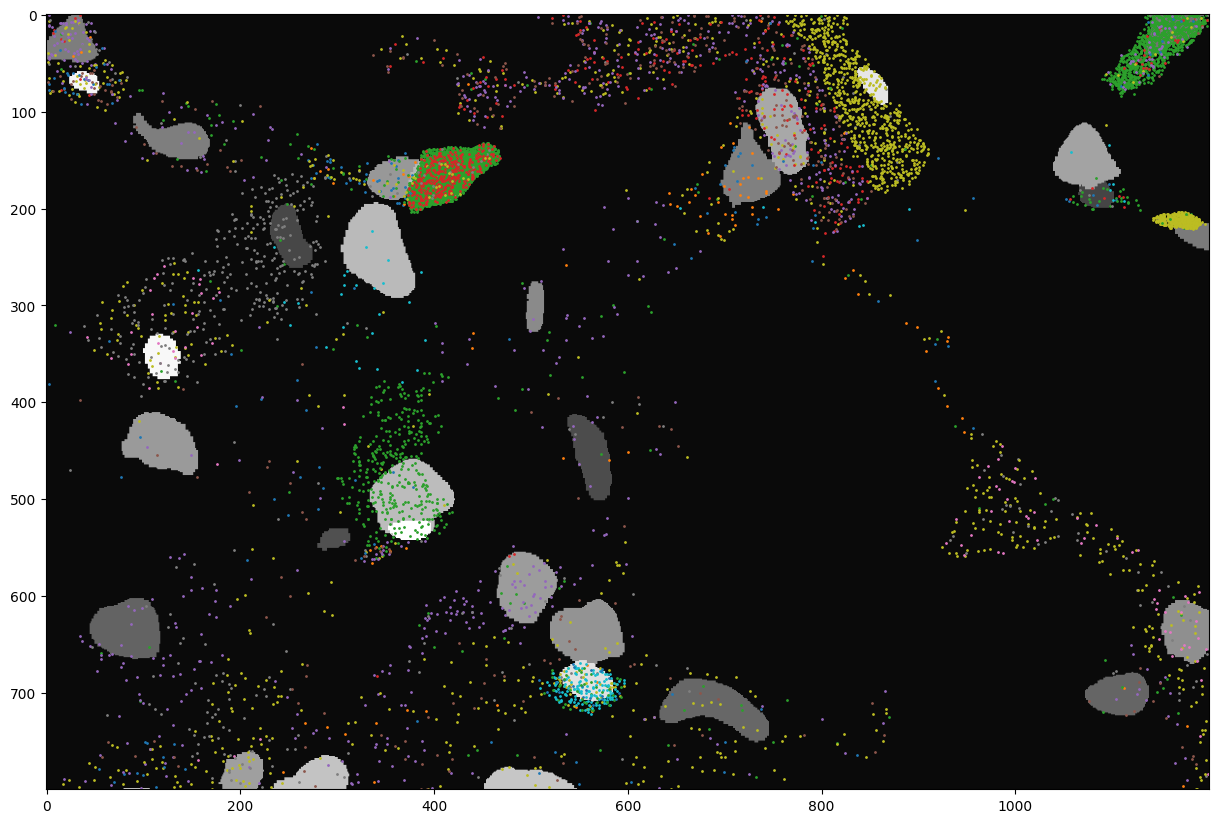

In [7]:
from matplotlib import colors
import pandas as pd
df_spots = pd.read_csv(Path(path_to_save_df) /(path_ic.stem + '.npy'))
mask_nuclei = tifffile.imread(Path(path_folder_mask_nuclei) / (path_ic.stem + '.tiff'))[20:35, 200:1000, :1200]  
mip_nuclei = np.amax(mask_nuclei, 0)

dico_spots_pos = {}
for gene in selected_gene:
    y = df_spots[df_spots["gene"] == gene]["y"]
    x = df_spots[df_spots["gene"] == gene]["x"]

    dico_spots_pos[gene] = list(zip( y, x))
    

fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(mip_nuclei > 0, cmap='gist_gray', alpha = 0.8)
ax.imshow(mip_nuclei, cmap='gist_gray', alpha = 0.8)
for gene in dico_spots_pos.keys():
    if len(dico_spots_pos[gene]) == 0:
        continue
    ax.scatter(np.array(dico_spots_pos[gene])[:,1], np.array(dico_spots_pos[gene])[:,0], cmap="Pastel1",  #  gene_color_dico[gene],   #'#%02X%02X%02X' % (r(),r(),r()),
               s=1)
plt.show()